In [18]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [41]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [42]:
%matplotlib inline

import os
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt

from analysis.sessions import selected_013608
from utils.neurosuite import get_unit_names_sorted

In [43]:
def get_idxs_as_periods(idxs_events):
    if len(idxs_events) == 0:
        return np.array([])
        
    idxs_to_idxs = np.where(np.diff(idxs_events) > 1)[0]
    if len(idxs_to_idxs) == 0:
        return np.array([idxs_events[0], idxs_events[-1]])
    
    # periods - indices to TL where was silent
    periods       = np.zeros([len(idxs_to_idxs) + 1, 2])
    periods[0]    = np.array([0, idxs_to_idxs[0]])
    periods[1:-1] = np.column_stack([idxs_to_idxs[:-1] + 1, idxs_to_idxs[1:]])
    periods[-1]   = np.array([idxs_to_idxs[-1]+1, len(idxs_events) - 1])
    periods       = periods.astype(np.int32)
    
    periods_ev = []
    for per in periods:
        periods_ev.append([idxs_events[per[0]], idxs_events[per[1]]])
    return np.array(periods_ev, dtype=np.int32)

In [80]:
#source  = '/Users/andrey/sandbox/'
source  = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
#source  = '/mnt/nevermind.data-share/ag-grothe/AG_Pecka/data/processed/'

#session = '013608_ppcSIT_2025-01-23_08-46-51'  # HPC

selected_013608[:1]

['013608_ppcSIT_2025-01-06_13-20-52']

In [125]:
speed_max = 0.04  # m/s

for session in selected_013608[:1]:
    animal      = session.split('_')[0]
    meta_file   = os.path.join(source, animal, session, 'meta.h5')
    units_file  = os.path.join(source, animal, session, 'units.h5')
    
    # reading events and spiking data
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        sound_events = np.array(f['processed']['sound_events'])
        cfg = json.loads(f['processed'].attrs['parameters'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        
    speed_ev = tl[sound_events[:, 2].astype(np.int32)][:, 3]
    idxs_sta_ev = np.where(speed_ev < speed_max)[0]
    idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
    idxs_di1_ev = np.where(sound_events[:, 1] == 3)[0]
    idxs_di2_ev = np.where(sound_events[:, 1] == 4)[0]

    periods_sta_bgr_ev = get_idxs_as_periods(np.intersect1d(idxs_sta_ev, idxs_bgr_ev))
    
    spike_times = {}
    inst_rates = {}
    with h5py.File(units_file, 'r') as f:
        unit_names = get_unit_names_sorted([name for name in f])
        for unit_name in f:
            spike_times[unit_name] = np.array(f[unit_name]['spike_times'])
            inst_rates[unit_name] = np.array(f[unit_name]['inst_rate'])

(0.0, 1000.0)

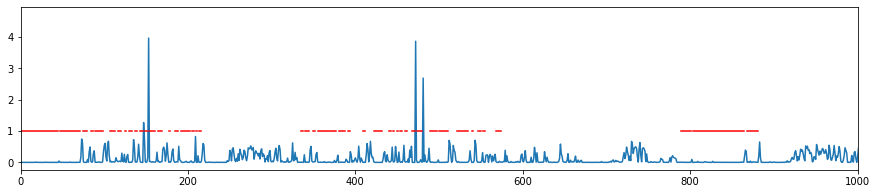

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(speed_ev)
for period in periods_sta_bgr_ev:
    ax.plot(period, np.ones(2), color='red')
ax.set_xlim(0, 1000)

(array([127., 107.,  61.,  56.,  36.,  28.,  34.,  19.,  13.,   8.,  13.,
          7.,   5.,   6.,   1.,   4.,   6.,   0.,   4.,   2.,   1.,   1.,
          1.,   0.,   2.,   0.,   2.,   2.,   1.,   0.,   0.,   1.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40.]),
 <BarContainer object of 40 artists>)

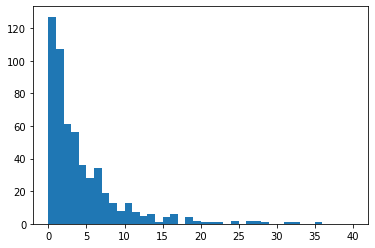

In [83]:
plt.hist(np.diff(periods_sta_bgr_ev, axis=1), bins=np.linspace(0, 40, 41))

In [84]:
# filter by speed 0.04
# then compute periods in events space
# then hist

In [85]:
# how many?
len(np.where(np.diff(periods_sta, axis=1) > 12)[0])

17

In [122]:
bins_back = 8
bins_fut  = 16
periods_filt = periods_sta_bgr_ev[np.where(np.diff(periods_sta_bgr_ev, axis=1) > 12)[0]]
#periods_filt = periods_sta_bgr_ev

st = spike_times['1-137']
collected = np.zeros([len(periods_filt), bins_back + bins_fut])
for i, period in enumerate(periods_filt):
    if not period[0] - bins_back > 0:  # too early
        continue
        
    bc = np.array([period[1] - period[0], bins_fut]).min()
    bins = np.arange(period[0] - bins_back, period[0] + bc + 1)
    
    bc_to_add = (bins_back + bins_fut) - len(bins) + 1
    bins_to_add = np.array([np.nan for x in range(bc_to_add)])
    
    
    counts, _ = np.histogram(st, bins=sound_events[bins][:, 0])
    
    #print(period, bins, bins_to_add)
    collected[i] = np.concatenate([counts, bins_to_add])

In [127]:
hist_bins = np.arange(-bins_back, bins_fut)
hist_counts = np.zeros(collected.shape[1])
for i, bin_vals in enumerate(collected.T):
    spike_count = np.nansum(bin_vals)
    per_count = len(bin_vals) - np.isnan(bin_vals).sum()
    hist_counts[i] = (spike_count / per_count) / 0.25

<BarContainer object of 24 artists>

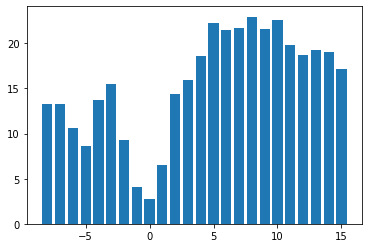

In [128]:
plt.bar(hist_bins, hist_counts)

In [126]:
# speed corr
np.corrcoef(inst_rates['1-137'], tl[:, 3])

array([[ 1.        , -0.35051242],
       [-0.35051242,  1.        ]])

In [131]:
idxs_vectors_ev = periods_filt[:, 0]

In [ ]:
# try diff offsets
corr_medians = []
pulses_rel = [x for x in range(-15, 40)]
for offset in pulses_rel:
    corr_mx_t = np.zeros([len(idxs_vectors_ev), len(idxs_vectors_ev)])
    for i, idx_1 in enumerate(idxs_vectors_ev):
        for j, idx_2 in enumerate(idxs_vectors_ev):
            corr_mx_t[i][j] = np.corrcoef(unit_mx[idx_1+offset], unit_mx[idx_2+offset])[0][1]
            
    corrs = corr_mx_t.flatten()
    corrs = corrs[corrs < 0.9]
    corr_medians.append(np.median(corrs))